# Preprocessing dan Visualisasi Data Deforestasi Indonesia

Notebook ini melakukan:
1. Load 3 dataset (luas hutan alam, emisi CO2, deforestasi)
2. Merging dataset dengan menghapus fitur duplikat
3. Preprocessing fitur deforestasi dan emisi karbon
4. Visualisasi scatter plot

In [9]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set style untuk visualisasi
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

## 1. Load Dataset

In [12]:
# Path ke dataset
# Sesuaikan nama file sesuai folder dataset_visdat
path_luas_hutan = 'dataset_visdat\spatial-metrics-indonesia-remaining_forest_province.csv'
path_emisi_co2 = 'dataset_visdat\spatial-metrics-indonesia-co2_gross_emissions_territorial_deforestation_province.csv'
path_deforestasi = 'dataset_visdat\spatial-metrics-indonesia-territorial_deforestation_province (1).csv'

# Load datasets
df_hutan = pd.read_csv(path_luas_hutan)
df_emisi = pd.read_csv(path_emisi_co2)
df_deforestasi = pd.read_csv(path_deforestasi)

print("Dataset Luas Hutan Alam:")
print(f"Shape: {df_hutan.shape}")
print(f"Columns: {df_hutan.columns.tolist()}\n")
display(df_hutan.head())

print("Dataset Emisi CO2:")
print(f"Shape: {df_emisi.shape}")
print(f"Columns: {df_emisi.columns.tolist()}\n")
display(df_emisi.head())

print("Dataset Deforestasi:")
print(f"Shape: {df_deforestasi.shape}")
print(f"Columns: {df_deforestasi.columns.tolist()}")
display(df_deforestasi.head())

Dataset Luas Hutan Alam:
Shape: (748, 8)
Columns: ['year', 'country', 'country_iso2', 'region', 'region_trase_id', 'parent_region', 'parent_region_trase_id', 'natural_forest_area_hectares']



,year,country,country_iso2,region,region_trase_id,parent_region,parent_region_trase_id,natural_forest_area_hectares
0,2001,INDONESIA,ID,ACEH,ID-11,SUMATERA,ID-SM,3.624507e+06
1,2001,INDONESIA,ID,BALI,ID-51,NUSA TENGGARA,ID-NU,6.375161e+04
2,2001,INDONESIA,ID,BANTEN,ID-36,JAWA,ID-JW,6.599245e+04
3,2001,INDONESIA,ID,BENGKULU,ID-17,SUMATERA,ID-SM,2.682920e+05
4,2001,INDONESIA,ID,D I YOGYAKARTA,ID-34,JAWA,ID-JW,1.080000e+01


Dataset Emisi CO2:
Shape: (748, 8)
Columns: ['year', 'country', 'country_iso2', 'region', 'region_trase_id', 'parent_region', 'parent_region_trase_id', 'gross_greenhouse_gas_emissions_from_deforestation_tonnes_co₂-']



,year,country,country_iso2,region,region_trase_id,parent_region,parent_region_trase_id,gross_greenhouse_gas_emissions_from_deforestation_tonnes_co₂-
0,2001,INDONESIA,ID,ACEH,ID-11,SUMATERA,ID-SM,1.782574e+06
1,2001,INDONESIA,ID,BALI,ID-51,NUSA TENGGARA,ID-NU,1.907890e+03
2,2001,INDONESIA,ID,BANTEN,ID-36,JAWA,ID-JW,4.650027e+02
3,2001,INDONESIA,ID,BENGKULU,ID-17,SUMATERA,ID-SM,9.558148e+05
4,2001,INDONESIA,ID,D I YOGYAKARTA,ID-34,JAWA,ID-JW,0.000000e+00


Dataset Deforestasi:
Shape: (748, 8)
Columns: ['year', 'country', 'country_iso2', 'region', 'region_trase_id', 'parent_region', 'parent_region_trase_id', 'deforestation_hectares']


,year,country,country_iso2,region,region_trase_id,parent_region,parent_region_trase_id,deforestation_hectares
0,2001,INDONESIA,ID,ACEH,ID-11,SUMATERA,ID-SM,4097.692235
1,2001,INDONESIA,ID,BALI,ID-51,NUSA TENGGARA,ID-NU,5.130000
2,2001,INDONESIA,ID,BANTEN,ID-36,JAWA,ID-JW,1.260000
3,2001,INDONESIA,ID,BENGKULU,ID-17,SUMATERA,ID-SM,1906.404000
4,2001,INDONESIA,ID,D I YOGYAKARTA,ID-34,JAWA,ID-JW,0.000000


In [29]:
"""
Script untuk Agregasi Data Deforestasi per Provinsi dan Visualisasi
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 10)

print("="*70)
print("AGREGASI DATA DEFORESTASI DAN EMISI CO2 PER PROVINSI")
print("="*70)

# ============================================================================
# 2. IDENTIFIKASI KOLOM KUNCI
# ============================================================================
print("\n[2] Identifikasi kolom kunci...")

# Cari kolom provinsi dan tahun
def find_column(df, keywords):
    """Mencari kolom berdasarkan keywords"""
    for col in df.columns:
        if any(keyword in col.lower() for keyword in keywords):
            return col
    return None

province_col = find_column(df_deforestasi, ['province', 'area', 'region', 'location'])
year_col = find_column(df_deforestasi, ['year', 'time', 'date'])

print(f"✓ Kolom Provinsi: {province_col}")
print(f"✓ Kolom Tahun: {year_col}")

# Cari kolom nilai numerik untuk deforestasi dan emisi
deforestasi_value_col = [col for col in df_deforestasi.columns 
                          if col not in [province_col, year_col] 
                          and df_deforestasi[col].dtype in ['float64', 'int64']][0]

emisi_value_col = [col for col in df_emisi.columns 
                   if col not in [province_col, year_col] 
                   and df_emisi[col].dtype in ['float64', 'int64']][0]

hutan_value_col = [col for col in df_hutan.columns 
                   if col not in [province_col, year_col] 
                   and df_hutan[col].dtype in ['float64', 'int64']][0]

print(f"✓ Kolom Nilai Deforestasi: {deforestasi_value_col}")
print(f"✓ Kolom Nilai Emisi: {emisi_value_col}")
print(f"✓ Kolom Nilai Luas Hutan: {hutan_value_col}")

# ============================================================================
# 3. FILTER DATA TAHUN 2012-2022
# ============================================================================
print("\n[3] Filtering data tahun 2012-2022...")

# Filter dataset
df_hutan = df_hutan[(df_hutan[year_col] >= 2012) & (df_hutan[year_col] <= 2022)]
df_emisi = df_emisi[(df_emisi[year_col] >= 2012) & (df_emisi[year_col] <= 2022)]
df_deforestasi = df_deforestasi[(df_deforestasi[year_col] >= 2012) & (df_deforestasi[year_col] <= 2022)]

print(f"✓ Dataset Luas Hutan (2012-2022): {df_hutan.shape}")
print(f"✓ Dataset Emisi CO2 (2012-2022): {df_emisi.shape}")
print(f"✓ Dataset Deforestasi (2012-2022): {df_deforestasi.shape}")

# Cek range tahun
print(f"\nRange tahun dalam data:")
print(f"  - Hutan: {df_hutan[year_col].min()} - {df_hutan[year_col].max()}")
print(f"  - Emisi: {df_emisi[year_col].min()} - {df_emisi[year_col].max()}")
print(f"  - Deforestasi: {df_deforestasi[year_col].min()} - {df_deforestasi[year_col].max()}")

# ============================================================================
# 4. AGREGASI PER PROVINSI
# ============================================================================
print("\n[4] Melakukan agregasi per provinsi...")

# Agregasi Deforestasi: Total per provinsi (sum)
df_deforestasi_agg = df_deforestasi.groupby(province_col).agg({
    deforestasi_value_col: ['sum', 'mean', 'std', 'min', 'max'],
    year_col: 'count'  # Hitung jumlah data per provinsi
}).reset_index()

df_deforestasi_agg.columns = [
    'province', 
    'total_deforestasi', 
    'avg_deforestasi', 
    'std_deforestasi',
    'min_deforestasi',
    'max_deforestasi',
    'num_years'
]

# Agregasi Emisi CO2: Total per provinsi (sum)
df_emisi_agg = df_emisi.groupby(province_col).agg({
    emisi_value_col: ['sum', 'mean', 'std', 'min', 'max']
}).reset_index()

df_emisi_agg.columns = [
    'province',
    'total_emisi',
    'avg_emisi',
    'std_emisi',
    'min_emisi',
    'max_emisi'
]

# Agregasi Luas Hutan: Rata-rata per provinsi
df_hutan_agg = df_hutan.groupby(province_col).agg({
    hutan_value_col: ['mean', 'min', 'max']
}).reset_index()

df_hutan_agg.columns = [
    'province',
    'avg_luas_hutan',
    'min_luas_hutan',
    'max_luas_hutan'
]

print(f"✓ Deforestasi agregat: {df_deforestasi_agg.shape}")
print(f"✓ Emisi CO2 agregat: {df_emisi_agg.shape}")
print(f"✓ Luas Hutan agregat: {df_hutan_agg.shape}")

# ============================================================================
# 5. MERGE HASIL AGREGASI
# ============================================================================
print("\n[5] Merging hasil agregasi...")

df_agregat = df_deforestasi_agg.merge(df_emisi_agg, on='province', how='outer')
df_agregat = df_agregat.merge(df_hutan_agg, on='province', how='outer')

print(f"✓ Data agregat final: {df_agregat.shape}")
print(f"✓ Jumlah provinsi: {df_agregat['province'].nunique()}")

# Handle missing values
print(f"\nMissing values sebelum cleaning:")
print(df_agregat.isnull().sum())

df_agregat = df_agregat.dropna(subset=['total_deforestasi', 'total_emisi'])

print(f"\n✓ Data setelah drop NA: {df_agregat.shape}")

# ============================================================================
# 6. STATISTIK DESKRIPTIF
# ============================================================================
print("\n[6] Statistik Deskriptif Per Provinsi:")
print("="*70)

print("\nTOTAL DEFORESTASI:")
print(df_agregat['total_deforestasi'].describe())

print("\nTOTAL EMISI CO2:")
print(df_agregat['total_emisi'].describe())

print("\nRATA-RATA LUAS HUTAN:")
print(df_agregat['avg_luas_hutan'].describe())

# Top 10 provinsi dengan deforestasi tertinggi
print("\n" + "="*70)
print("TOP 10 PROVINSI DENGAN DEFORESTASI TERTINGGI:")
print("="*70)
top_10_deforestasi = df_agregat.nlargest(10, 'total_deforestasi')[['province', 'total_deforestasi', 'total_emisi']]
for idx, row in top_10_deforestasi.iterrows():
    print(f"{row['province']:30s} | Deforestasi: {row['total_deforestasi']:,.0f} | Emisi: {row['total_emisi']:,.0f}")

# ============================================================================
# 7. VISUALISASI SCATTER PLOT
# ============================================================================
print("\n[7] Membuat visualisasi scatter plot...")

# Hitung korelasi
correlation = df_agregat[['total_deforestasi', 'total_emisi']].corr().iloc[0, 1]
print(f"\n✓ Korelasi Deforestasi vs Emisi CO2: {correlation:.4f}")

# ============================================================================
# SCATTER PLOT 1: Basic dengan Color Gradient
# ============================================================================
fig, ax = plt.subplots(figsize=(14, 10))

# Scatter plot dengan color gradient berdasarkan luas hutan
scatter = ax.scatter(df_agregat['total_deforestasi'], 
                     df_agregat['total_emisi'],
                     s=200,  # Ukuran titik lebih besar
                     c=df_agregat['avg_luas_hutan'],  # Warna berdasarkan luas hutan
                     cmap='RdYlGn',  # Red-Yellow-Green (merah=sedikit hutan, hijau=banyak hutan)
                     alpha=0.7,
                     edgecolors='black',
                     linewidths=1.5)

# Tambahkan colorbar
cbar = plt.colorbar(scatter, ax=ax, label='Rata-rata Luas Hutan (ha)')
cbar.ax.tick_params(labelsize=10)

# Label dan title
ax.set_xlabel('Total Deforestasi (Hektar)', fontsize=14, fontweight='bold')
ax.set_ylabel('Total Emisi CO2 (Ton)', fontsize=14, fontweight='bold')
ax.set_title('Hubungan Deforestasi dan Emisi CO2 per Provinsi di Indonesia\n(2012-2022)', 
             fontsize=16, fontweight='bold', pad=20)

# Grid
ax.grid(True, alpha=0.3, linestyle='--')

# Regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(
    df_agregat['total_deforestasi'], 
    df_agregat['total_emisi']
)
line = slope * df_agregat['total_deforestasi'] + intercept
ax.plot(df_agregat['total_deforestasi'], line, 'r--', linewidth=2, 
        alpha=0.8, label=f'Regression Line (R²={r_value**2:.3f})')

# Tambahkan teks statistik
textstr = f'Korelasi: {correlation:.4f}\nR²: {r_value**2:.3f}\np-value: {p_value:.2e}\nn = {len(df_agregat)} provinsi'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props)

ax.legend(loc='lower right', fontsize=11)
plt.tight_layout()
plt.savefig('scatter_plot_1_basic.png', dpi=300, bbox_inches='tight')
print("✓ Scatter plot 1 saved: scatter_plot_1_basic.png")
plt.close()

# ============================================================================
# SCATTER PLOT 2: Dengan Label Top 10 Provinsi
# ============================================================================
fig, ax = plt.subplots(figsize=(16, 11))

# Scatter plot untuk semua provinsi
ax.scatter(df_agregat['total_deforestasi'], 
           df_agregat['total_emisi'],
           s=150,
           c='lightgray',
           alpha=0.5,
           edgecolors='gray',
           linewidths=1,
           label='Provinsi Lainnya')

# Highlight top 10 provinsi
top_10 = df_agregat.nlargest(10, 'total_deforestasi')
scatter_top = ax.scatter(top_10['total_deforestasi'], 
                         top_10['total_emisi'],
                         s=300,
                         c=range(len(top_10)),
                         cmap='Reds',
                         alpha=0.8,
                         edgecolors='darkred',
                         linewidths=2,
                         label='Top 10 Provinsi',
                         zorder=5)

# Annotate top 10 provinsi dengan posisi yang tidak overlap
for idx, row in top_10.iterrows():
    ax.annotate(row['province'], 
                xy=(row['total_deforestasi'], row['total_emisi']),
                xytext=(10, 10),
                textcoords='offset points',
                fontsize=9,
                fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7, edgecolor='black'),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3', color='black', lw=1.5))

# Label dan title
ax.set_xlabel('Total Deforestasi (Hektar)', fontsize=14, fontweight='bold')
ax.set_ylabel('Total Emisi CO2 (Ton)', fontsize=14, fontweight='bold')
ax.set_title('Top 10 Provinsi dengan Deforestasi Tertinggi\ndan Kontribusi Emisi CO2 (2012-2022)', 
             fontsize=16, fontweight='bold', pad=20)

# Grid
ax.grid(True, alpha=0.3, linestyle='--')

# Regression line
ax.plot(df_agregat['total_deforestasi'], line, 'r--', linewidth=2, 
        alpha=0.8, label=f'Regression Line (R²={r_value**2:.3f})')

# Statistik
textstr = f'Korelasi: {correlation:.4f}\nR²: {r_value**2:.3f}\nn = {len(df_agregat)} provinsi'
props = dict(boxstyle='round', facecolor='lightblue', alpha=0.8)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props)

# Colorbar untuk top 10
cbar = plt.colorbar(scatter_top, ax=ax, label='Ranking Deforestasi')
cbar.ax.tick_params(labelsize=10)

ax.legend(loc='lower right', fontsize=11)
plt.tight_layout()
plt.savefig('scatter_plot_2_top10.png', dpi=300, bbox_inches='tight')
print("✓ Scatter plot 2 saved: scatter_plot_2_top10.png")
plt.close()

# ============================================================================
# SCATTER PLOT 3: Kategorisasi berdasarkan Pulau
# ============================================================================
print("\n[8] Membuat scatter plot dengan kategorisasi pulau...")

# Kategorisasi provinsi berdasarkan pulau
def categorize_island(province_name):
    """Kategorisasi provinsi ke pulau"""
    province_name = province_name.lower()
    
    if any(x in province_name for x in ['aceh', 'sumatera', 'sumatra', 'lampung', 'bengkulu', 'jambi', 'riau', 'babel']):
        return 'Sumatera'
    elif any(x in province_name for x in ['jakarta', 'jawa', 'banten', 'yogya', 'diy']):
        return 'Jawa'
    elif any(x in province_name for x in ['kalimantan', 'borneo']):
        return 'Kalimantan'
    elif any(x in province_name for x in ['sulawesi', 'gorontalo']):
        return 'Sulawesi'
    elif any(x in province_name for x in ['papua', 'irian']):
        return 'Papua'
    elif any(x in province_name for x in ['bali', 'nusa tenggara', 'ntb', 'ntt']):
        return 'Bali & Nusa Tenggara'
    elif any(x in province_name for x in ['maluku']):
        return 'Maluku'
    else:
        return 'Lainnya'

df_agregat['pulau'] = df_agregat['province'].apply(categorize_island)

# Color mapping untuk pulau
island_colors = {
    'Sumatera': '#FF6B6B',
    'Jawa': '#4ECDC4',
    'Kalimantan': '#45B7D1',
    'Sulawesi': '#FFA07A',
    'Papua': '#98D8C8',
    'Bali & Nusa Tenggara': '#F7DC6F',
    'Maluku': '#BB8FCE',
    'Lainnya': '#95A5A6'
}

fig, ax = plt.subplots(figsize=(16, 10))

# Plot setiap pulau dengan warna berbeda
for island, color in island_colors.items():
    island_data = df_agregat[df_agregat['pulau'] == island]
    if len(island_data) > 0:
        ax.scatter(island_data['total_deforestasi'], 
                   island_data['total_emisi'],
                   s=200,
                   c=color,
                   alpha=0.7,
                   edgecolors='black',
                   linewidths=1.5,
                   label=f'{island} (n={len(island_data)})')

# Label dan title
ax.set_xlabel('Total Deforestasi (Hektar)', fontsize=14, fontweight='bold')
ax.set_ylabel('Total Emisi CO2 (Ton)', fontsize=14, fontweight='bold')
ax.set_title('Hubungan Deforestasi dan Emisi CO2 per Provinsi\nKategorisasi Berdasarkan Pulau (2012-2022)', 
             fontsize=16, fontweight='bold', pad=20)

# Grid
ax.grid(True, alpha=0.3, linestyle='--')

# Regression line
ax.plot(df_agregat['total_deforestasi'], line, 'k--', linewidth=2, 
        alpha=0.6, label=f'Regression Line (R²={r_value**2:.3f})')

# Legend
ax.legend(loc='upper left', fontsize=10, framealpha=0.9, ncol=2)

# Statistik
textstr = f'Korelasi: {correlation:.4f}\nR²: {r_value**2:.3f}\nn = {len(df_agregat)} provinsi'
props = dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black')
ax.text(0.98, 0.02, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='bottom', horizontalalignment='right', bbox=props)

plt.tight_layout()
plt.savefig('scatter_plot_3_pulau.png', dpi=300, bbox_inches='tight')
print("✓ Scatter plot 3 saved: scatter_plot_3_pulau.png")
plt.close()

# ============================================================================
# 9. SIMPAN DATA AGREGAT
# ============================================================================
print("\n[9] Menyimpan data agregat...")

output_csv = 'data_agregat_per_provinsi.csv'
df_agregat.to_csv(output_csv, index=False)
print(f"✓ Data agregat disimpan: {output_csv}")

# ============================================================================
# 10. SUMMARY REPORT
# ============================================================================
print("\n" + "="*70)
print("SUMMARY REPORT")
print("="*70)
print(f"Total Provinsi: {len(df_agregat)}")
print(f"\nTotal Deforestasi Nasional: {df_agregat['total_deforestasi'].sum():,.0f} hektar")
print(f"Total Emisi CO2 Nasional: {df_agregat['total_emisi'].sum():,.0f} ton")
print(f"Rata-rata Luas Hutan: {df_agregat['avg_luas_hutan'].mean():,.0f} hektar")
print(f"\nKorelasi Deforestasi-Emisi: {correlation:.4f}")
print(f"R² (Coefficient of Determination): {r_value**2:.4f}")
print(f"P-value: {p_value:.2e}")

print("\nDistribusi per Pulau:")
pulau_summary = df_agregat.groupby('pulau').agg({
    'total_deforestasi': 'sum',
    'total_emisi': 'sum',
    'province': 'count'
}).round(0)
pulau_summary.columns = ['Total Deforestasi', 'Total Emisi CO2', 'Jumlah Provinsi']
print(pulau_summary.sort_values('Total Deforestasi', ascending=False))

print("\n" + "="*70)
print("SELESAI! Semua visualisasi telah disimpan.")
print("="*70)

AGREGASI DATA DEFORESTASI DAN EMISI CO2 PER PROVINSI

[2] Identifikasi kolom kunci...
✓ Kolom Provinsi: region
✓ Kolom Tahun: year
✓ Kolom Nilai Deforestasi: deforestation_hectares
✓ Kolom Nilai Emisi: gross_greenhouse_gas_emissions_from_deforestation_tonnes_co₂-
✓ Kolom Nilai Luas Hutan: natural_forest_area_hectares

[3] Filtering data tahun 2012-2022...
✓ Dataset Luas Hutan (2012-2022): (374, 8)
✓ Dataset Emisi CO2 (2012-2022): (374, 8)
✓ Dataset Deforestasi (2012-2022): (374, 8)

Range tahun dalam data:
  - Hutan: 2012 - 2022
  - Emisi: 2012 - 2022
  - Deforestasi: 2012 - 2022

[4] Melakukan agregasi per provinsi...
✓ Deforestasi agregat: (34, 7)
✓ Emisi CO2 agregat: (34, 6)
✓ Luas Hutan agregat: (34, 4)

[5] Merging hasil agregasi...
✓ Data agregat final: (34, 15)
✓ Jumlah provinsi: 34

Missing values sebelum cleaning:
province             0
total_deforestasi    0
avg_deforestasi      0
std_deforestasi      0
min_deforestasi      0
max_deforestasi      0
num_years            0
tota

## 2. Merging Dataset dengan Menghapus Fitur Duplikat

In [14]:
# Identifikasi kolom untuk merge (biasanya province/area dan year)
# Kita cek kolom yang sama di semua dataset
cols_hutan = set(df_hutan.columns)
cols_emisi = set(df_emisi.columns)
cols_deforestasi = set(df_deforestasi.columns)

# Kolom yang ada di semua dataset (untuk merge key)
common_cols = cols_hutan & cols_emisi & cols_deforestasi
print(f"Kolom yang sama di semua dataset: {common_cols}")

# Tentukan key untuk merge (biasanya province/area_name dan year)
merge_keys = [col for col in common_cols if any(keyword in col.lower() for keyword in ['province', 'area', 'year', 'time'])]
print(f"\nMerge keys yang akan digunakan: {merge_keys}")

Kolom yang sama di semua dataset: {'parent_region', 'parent_region_trase_id', 'country', 'year', 'country_iso2', 'region_trase_id', 'region'}

Merge keys yang akan digunakan: ['year']


In [15]:
# Rename kolom untuk menghindari duplikat setelah merge
# Tambahkan suffix untuk kolom yang tidak menjadi merge key

# Untuk df_hutan
df_hutan_renamed = df_hutan.copy()
for col in df_hutan.columns:
    if col not in merge_keys:
        df_hutan_renamed.rename(columns={col: f"{col}_hutan"}, inplace=True)

# Untuk df_emisi
df_emisi_renamed = df_emisi.copy()
for col in df_emisi.columns:
    if col not in merge_keys:
        df_emisi_renamed.rename(columns={col: f"{col}_emisi"}, inplace=True)

# Untuk df_deforestasi
df_deforestasi_renamed = df_deforestasi.copy()
for col in df_deforestasi.columns:
    if col not in merge_keys:
        df_deforestasi_renamed.rename(columns={col: f"{col}_deforestasi"}, inplace=True)

print("Kolom setelah rename:")
print(f"df_hutan: {df_hutan_renamed.columns.tolist()}")
print(f"df_emisi: {df_emisi_renamed.columns.tolist()}")
print(f"df_deforestasi: {df_deforestasi_renamed.columns.tolist()}")

Kolom setelah rename:
df_hutan: ['year', 'country_hutan', 'country_iso2_hutan', 'region_hutan', 'region_trase_id_hutan', 'parent_region_hutan', 'parent_region_trase_id_hutan', 'natural_forest_area_hectares_hutan']
df_emisi: ['year', 'country_emisi', 'country_iso2_emisi', 'region_emisi', 'region_trase_id_emisi', 'parent_region_emisi', 'parent_region_trase_id_emisi', 'gross_greenhouse_gas_emissions_from_deforestation_tonnes_co₂-_emisi']
df_deforestasi: ['year', 'country_deforestasi', 'country_iso2_deforestasi', 'region_deforestasi', 'region_trase_id_deforestasi', 'parent_region_deforestasi', 'parent_region_trase_id_deforestasi', 'deforestation_hectares_deforestasi']


In [16]:
# Merge dataset
# Merge pertama: hutan + emisi
df_merged = pd.merge(df_hutan_renamed, df_emisi_renamed, on=merge_keys, how='outer')
print(f"Setelah merge pertama (hutan + emisi): {df_merged.shape}")

# Merge kedua: hasil merge + deforestasi
df_merged = pd.merge(df_merged, df_deforestasi_renamed, on=merge_keys, how='outer')
print(f"Setelah merge kedua (+ deforestasi): {df_merged.shape}")

print(f"\nKolom final: {df_merged.columns.tolist()}")
print(f"\nInfo dataset merged:")
df_merged.info()

Setelah merge pertama (hutan + emisi): (25432, 15)
Setelah merge kedua (+ deforestasi): (864688, 22)

Kolom final: ['year', 'country_hutan', 'country_iso2_hutan', 'region_hutan', 'region_trase_id_hutan', 'parent_region_hutan', 'parent_region_trase_id_hutan', 'natural_forest_area_hectares_hutan', 'country_emisi', 'country_iso2_emisi', 'region_emisi', 'region_trase_id_emisi', 'parent_region_emisi', 'parent_region_trase_id_emisi', 'gross_greenhouse_gas_emissions_from_deforestation_tonnes_co₂-_emisi', 'country_deforestasi', 'country_iso2_deforestasi', 'region_deforestasi', 'region_trase_id_deforestasi', 'parent_region_deforestasi', 'parent_region_trase_id_deforestasi', 'deforestation_hectares_deforestasi']

Info dataset merged:
Setelah merge kedua (+ deforestasi): (864688, 22)

Kolom final: ['year', 'country_hutan', 'country_iso2_hutan', 'region_hutan', 'region_trase_id_hutan', 'parent_region_hutan', 'parent_region_trase_id_hutan', 'natural_forest_area_hectares_hutan', 'country_emisi', 'co

In [17]:
# Preview data merged
display(df_merged.head(10))

,year,country_hutan,country_iso2_hutan,region_hutan,region_trase_id_hutan,parent_region_hutan,parent_region_trase_id_hutan,natural_forest_area_hectares_hutan,country_emisi,country_iso2_emisi,...,parent_region_emisi,parent_region_trase_id_emisi,gross_greenhouse_gas_emissions_from_deforestation_tonnes_co₂-_emisi,country_deforestasi,country_iso2_deforestasi,region_deforestasi,region_trase_id_deforestasi,parent_region_deforestasi,parent_region_trase_id_deforestasi,deforestation_hectares_deforestasi
0,2001,INDONESIA,ID,ACEH,ID-11,SUMATERA,ID-SM,3624507.148,INDONESIA,ID,...,SUMATERA,ID-SM,1782573.796,INDONESIA,ID,ACEH,ID-11,SUMATERA,ID-SM,4097.692235
1,2001,INDONESIA,ID,ACEH,ID-11,SUMATERA,ID-SM,3624507.148,INDONESIA,ID,...,SUMATERA,ID-SM,1782573.796,INDONESIA,ID,BALI,ID-51,NUSA TENGGARA,ID-NU,5.130000
2,2001,INDONESIA,ID,ACEH,ID-11,SUMATERA,ID-SM,3624507.148,INDONESIA,ID,...,SUMATERA,ID-SM,1782573.796,INDONESIA,ID,BANTEN,ID-36,JAWA,ID-JW,1.260000
3,2001,INDONESIA,ID,ACEH,ID-11,SUMATERA,ID-SM,3624507.148,INDONESIA,ID,...,SUMATERA,ID-SM,1782573.796,INDONESIA,ID,BENGKULU,ID-17,SUMATERA,ID-SM,1906.404000
4,2001,INDONESIA,ID,ACEH,ID-11,SUMATERA,ID-SM,3624507.148,INDONESIA,ID,...,SUMATERA,ID-SM,1782573.796,INDONESIA,ID,D I YOGYAKARTA,ID-34,JAWA,ID-JW,0.000000
5,2001,INDONESIA,ID,ACEH,ID-11,SUMATERA,ID-SM,3624507.148,INDONESIA,ID,...,SUMATERA,ID-SM,1782573.796,INDONESIA,ID,DKI JAKARTA,ID-31,JAWA,ID-JW,0.000000
6,2001,INDONESIA,ID,ACEH,ID-11,SUMATERA,ID-SM,3624507.148,INDONESIA,ID,...,SUMATERA,ID-SM,1782573.796,INDONESIA,ID,GORONTALO,ID-75,SULAWESI,ID-SL,595.103294
7,2001,INDONESIA,ID,ACEH,ID-11,SUMATERA,ID-SM,3624507.148,INDONESIA,ID,...,SUMATERA,ID-SM,1782573.796,INDONESIA,ID,JAMBI,ID-15,SUMATERA,ID-SM,17097.834000
8,2001,INDONESIA,ID,ACEH,ID-11,SUMATERA,ID-SM,3624507.148,INDONESIA,ID,...,SUMATERA,ID-SM,1782573.796,INDONESIA,ID,JAWA BARAT,ID-32,JAWA,ID-JW,458.828471
9,2001,INDONESIA,ID,ACEH,ID-11,SUMATERA,ID-SM,3624507.148,INDONESIA,ID,...,SUMATERA,ID-SM,1782573.796,INDONESIA,ID,JAWA TENGAH,ID-33,JAWA,ID-JW,134.076706


In [ ]:
# Cek missing values
print("Missing values per kolom:")
missing = df_merged.isnull().sum()
print(missing[missing > 0])
print(f"\nPersentase missing values: {(df_merged.isnull().sum().sum() / (df_merged.shape[0] * df_merged.shape[1]) * 100):.2f}%")

## 3. Preprocessing Fitur Deforestasi dan Emisi Karbon

In [18]:
# Identifikasi kolom deforestasi dan emisi karbon
deforestasi_cols = [col for col in df_merged.columns if 'deforestasi' in col.lower()]
emisi_cols = [col for col in df_merged.columns if 'emisi' in col.lower() or 'co2' in col.lower()]

print(f"Kolom Deforestasi: {deforestasi_cols}")
print(f"Kolom Emisi: {emisi_cols}")

Kolom Deforestasi: ['country_deforestasi', 'country_iso2_deforestasi', 'region_deforestasi', 'region_trase_id_deforestasi', 'parent_region_deforestasi', 'parent_region_trase_id_deforestasi', 'deforestation_hectares_deforestasi']
Kolom Emisi: ['country_emisi', 'country_iso2_emisi', 'region_emisi', 'region_trase_id_emisi', 'parent_region_emisi', 'parent_region_trase_id_emisi', 'gross_greenhouse_gas_emissions_from_deforestation_tonnes_co₂-_emisi']


In [19]:
# Statistik deskriptif sebelum preprocessing
print("Statistik Deforestasi:")
for col in deforestasi_cols:
    if df_merged[col].dtype in ['float64', 'int64']:
        print(f"\n{col}:")
        print(df_merged[col].describe())

print("\n" + "="*50)
print("Statistik Emisi CO2:")
for col in emisi_cols:
    if df_merged[col].dtype in ['float64', 'int64']:
        print(f"\n{col}:")
        print(df_merged[col].describe())

Statistik Deforestasi:

deforestation_hectares_deforestasi:
count    864688.000000
mean      13898.697182
std       28875.498813
min           0.000000
25%         417.120441
50%        2950.012412
75%       14626.304997
max      300781.703600
Name: deforestation_hectares_deforestasi, dtype: float64

Statistik Emisi CO2:

gross_greenhouse_gas_emissions_from_deforestation_tonnes_co₂-_emisi:
count    8.646880e+05
mean     5.818186e+06
std      1.116722e+07
min      0.000000e+00
25%      1.736199e+05
50%      1.366504e+06
75%      6.446564e+06
max      1.047637e+08
Name: gross_greenhouse_gas_emissions_from_deforestation_tonnes_co₂-_emisi, dtype: float64
count    8.646880e+05
mean     5.818186e+06
std      1.116722e+07
min      0.000000e+00
25%      1.736199e+05
50%      1.366504e+06
75%      6.446564e+06
max      1.047637e+08
Name: gross_greenhouse_gas_emissions_from_deforestation_tonnes_co₂-_emisi, dtype: float64


In [ ]:
# Handle missing values
# Buat copy untuk preprocessing
df_processed = df_merged.copy()

# Opsi 1: Drop rows dengan missing values di kolom penting
# Opsi 2: Fill dengan median/mean
# Kita akan coba drop dulu untuk analisis yang lebih akurat

print(f"Jumlah baris sebelum drop NA: {len(df_processed)}")

# Drop rows yang missing di kolom deforestasi atau emisi
important_cols = deforestasi_cols + emisi_cols
df_processed = df_processed.dropna(subset=[col for col in important_cols if col in df_processed.columns])

print(f"Jumlah baris setelah drop NA: {len(df_processed)}")
print(f"Data yang di-drop: {len(df_merged) - len(df_processed)} baris ({(len(df_merged) - len(df_processed))/len(df_merged)*100:.2f}%)")

In [ ]:
# Handle outliers menggunakan IQR method
def remove_outliers_iqr(df, columns, multiplier=1.5):
    """
    Remove outliers menggunakan IQR method
    """
    df_clean = df.copy()
    
    for col in columns:
        if df_clean[col].dtype in ['float64', 'int64']:
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1
            
            lower_bound = Q1 - multiplier * IQR
            upper_bound = Q3 + multiplier * IQR
            
            outliers_before = len(df_clean)
            df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
            outliers_removed = outliers_before - len(df_clean)
            
            if outliers_removed > 0:
                print(f"{col}: Removed {outliers_removed} outliers (range: {lower_bound:.2f} - {upper_bound:.2f})")
    
    return df_clean

print(f"Data sebelum remove outliers: {len(df_processed)}")
df_processed = remove_outliers_iqr(df_processed, deforestasi_cols + emisi_cols)
print(f"Data setelah remove outliers: {len(df_processed)}")

In [ ]:
# Normalisasi/Standardisasi (opsional, tergantung kebutuhan)
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Buat kolom baru untuk nilai yang sudah dinormalisasi
scaler = StandardScaler()

# Untuk deforestasi
for col in deforestasi_cols:
    if df_processed[col].dtype in ['float64', 'int64']:
        df_processed[f'{col}_normalized'] = scaler.fit_transform(df_processed[[col]])

# Untuk emisi
for col in emisi_cols:
    if df_processed[col].dtype in ['float64', 'int64']:
        df_processed[f'{col}_normalized'] = scaler.fit_transform(df_processed[[col]])

print("Kolom setelah normalisasi:")
print([col for col in df_processed.columns if 'normalized' in col])

In [ ]:
# Statistik setelah preprocessing
print("Statistik setelah preprocessing:")
display(df_processed.describe())

## 4. Visualisasi Scatter Plot

C:\Users\Naufal Haris\AppData\Local\Temp\ipykernel_19952\2849461775.py:20: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Naufal Haris\.conda\envs\multimedia_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Naufal Haris\.conda\envs\multimedia_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


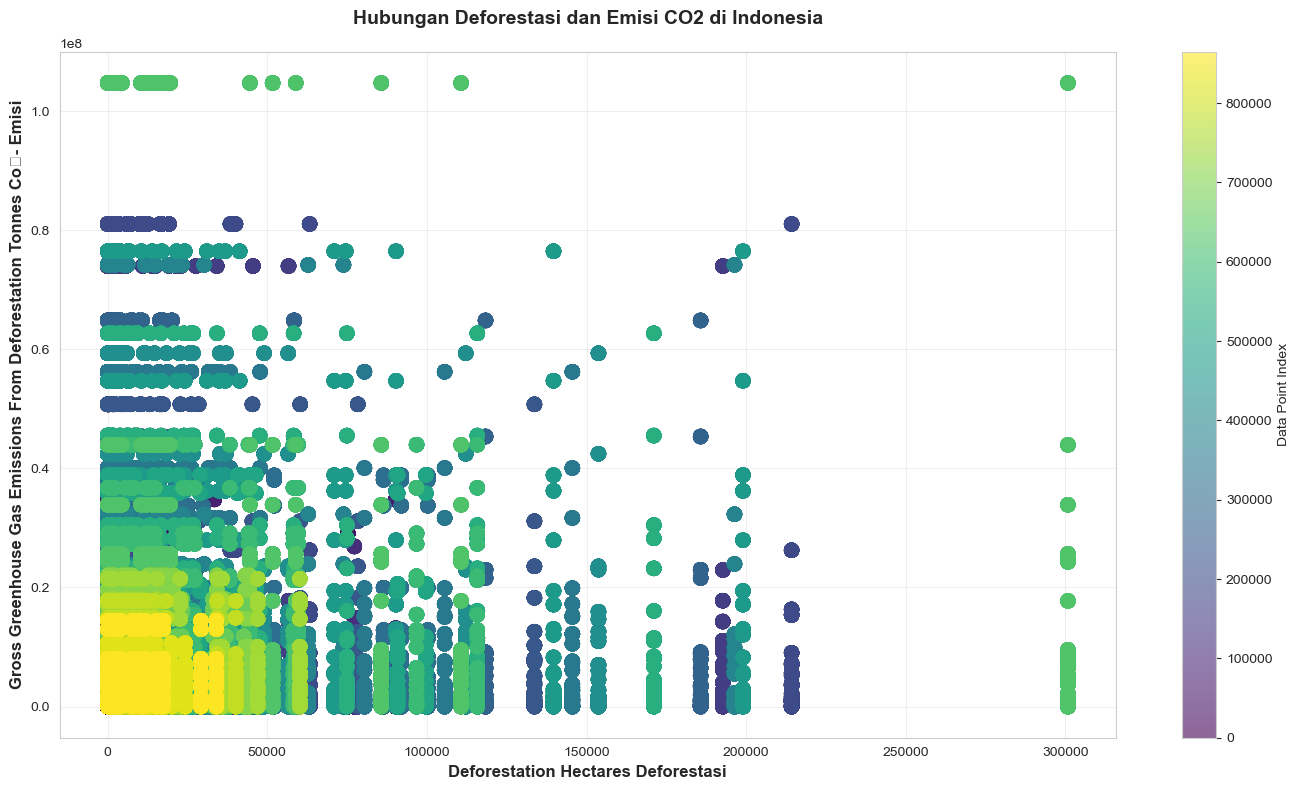

In [21]:
# Scatter plot: Deforestasi vs Emisi CO2
# Kita ambil kolom numerik pertama dari masing-masing kategori

deforestasi_col = [col for col in deforestasi_cols if df_merged[col].dtype in ['float64', 'int64']][0]
emisi_col = [col for col in emisi_cols if df_merged[col].dtype in ['float64', 'int64']][0]

plt.figure(figsize=(14, 8))
scatter = plt.scatter(df_merged[deforestasi_col], 
                     df_merged[emisi_col],
                     alpha=0.6, 
                     s=100,
                     c=df_merged.index,
                     cmap='viridis')

plt.xlabel(deforestasi_col.replace('_', ' ').title(), fontsize=12, fontweight='bold')
plt.ylabel(emisi_col.replace('_', ' ').title(), fontsize=12, fontweight='bold')
plt.title('Hubungan Deforestasi dan Emisi CO2 di Indonesia', fontsize=14, fontweight='bold', pad=20)
plt.colorbar(scatter, label='Data Point Index')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

AGREGASI DATA DEFORESTASI DAN EMISI CO2 PER PROVINSI

[1] Loading datasets...


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/project/spatial-metrics-indonesia-remaining_forest_province__1_.csv'

In [22]:
# Scatter plot dengan informasi provinsi (jika ada kolom province)
province_col = [col for col in merge_keys if 'province' in col.lower() or 'area' in col.lower()]

if province_col:
    province_col = province_col[0]
    
    # Ambil beberapa provinsi dengan nilai tertinggi
    top_provinces = df_merged.nlargest(10, deforestasi_col)
    
    plt.figure(figsize=(14, 10))
    
    # Plot semua data dengan warna abu-abu
    plt.scatter(df_merged[deforestasi_col], 
               df_merged[emisi_col],
               alpha=0.3, 
               s=80,
               c='gray',
               label='Provinsi Lainnya')
    
    # Highlight top provinces
    scatter = plt.scatter(top_provinces[deforestasi_col], 
                         top_provinces[emisi_col],
                         alpha=0.8, 
                         s=200,
                         c=range(len(top_provinces)),
                         cmap='Reds',
                         edgecolors='black',
                         linewidths=1,
                         label='Top 10 Provinsi')
    
    # Annotate top provinces
    for idx, row in top_provinces.iterrows():
        plt.annotate(row[province_col], 
                    (row[deforestasi_col], row[emisi_col]),
                    xytext=(5, 5), 
                    textcoords='offset points',
                    fontsize=8,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5))
    
    plt.xlabel(deforestasi_col.replace('_', ' ').title(), fontsize=12, fontweight='bold')
    plt.ylabel(emisi_col.replace('_', ' ').title(), fontsize=12, fontweight='bold')
    plt.title('Top 10 Provinsi dengan Deforestasi Tertinggi dan Emisi CO2', fontsize=14, fontweight='bold', pad=20)
    plt.legend()
    plt.colorbar(scatter, label='Ranking')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

NameError: name 'df_processed' is not defined

c:\Users\Naufal Haris\.conda\envs\multimedia_env\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  func(*args, **kwargs)
c:\Users\Naufal Haris\.conda\envs\multimedia_env\lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\Naufal Haris\.conda\envs\multimedia_env\lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\Naufal Haris\.conda\envs\multimedia_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Naufal Haris\.conda\envs\multimedia_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of 

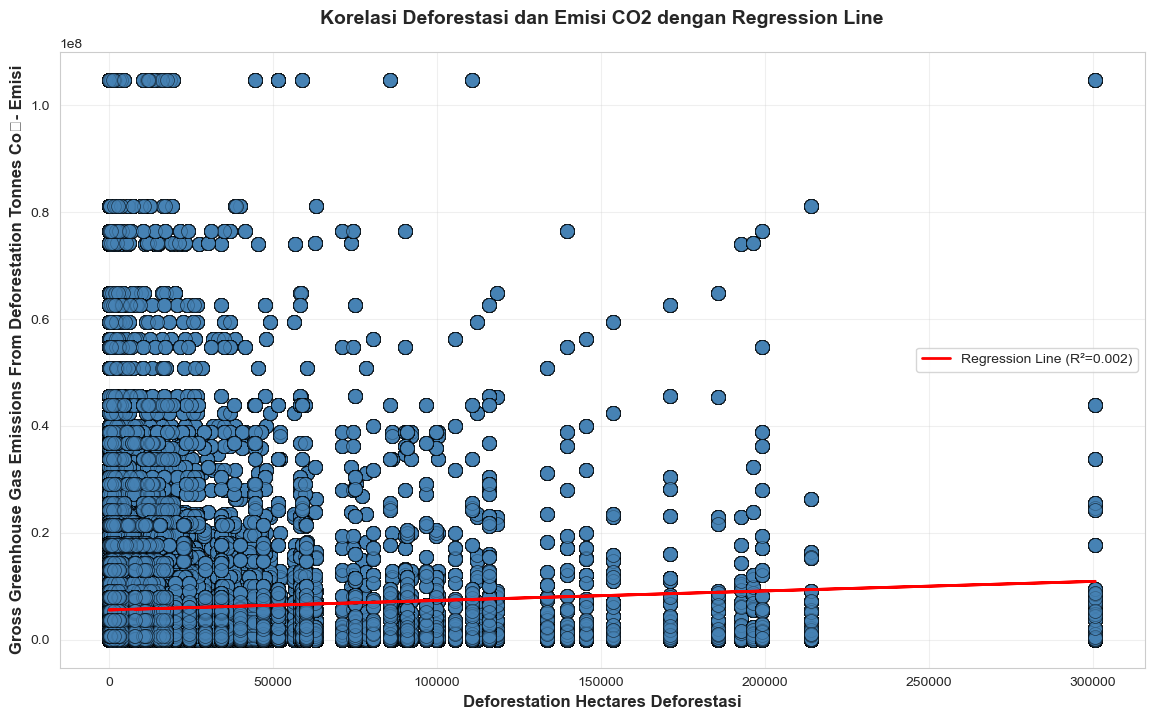

In [23]:
# Scatter plot dengan regression line
from scipy import stats

plt.figure(figsize=(14, 8))

# Scatter plot
plt.scatter(df_merged[deforestasi_col], 
           df_merged[emisi_col],
           alpha=0.6, 
           s=100,
           c='steelblue',
           edgecolors='black',
           linewidths=0.5)

# Calculate regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(df_merged[deforestasi_col], 
                                                                 df_merged[emisi_col])
line = slope * df_merged[deforestasi_col] + intercept
plt.plot(df_merged[deforestasi_col], line, 'r-', linewidth=2, 
         label=f'Regression Line (R²={r_value**2:.3f})')

plt.xlabel(deforestasi_col.replace('_', ' ').title(), fontsize=12, fontweight='bold')
plt.ylabel(emisi_col.replace('_', ' ').title(), fontsize=12, fontweight='bold')
plt.title('Korelasi Deforestasi dan Emisi CO2 dengan Regression Line', fontsize=14, fontweight='bold', pad=20)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Tambahkan teks korelasi
correlation = df_processed[[deforestasi_col, emisi_col]].corr().iloc[0, 1]
plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}\np-value: {p_value:.4e}', 
         transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
         fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
# Correlation heatmap untuk semua variabel numerik
numeric_cols = df_processed.select_dtypes(include=['float64', 'int64']).columns
# Pilih beberapa kolom penting saja untuk heatmap
important_numeric_cols = [col for col in numeric_cols if any(x in col.lower() for x in ['deforestasi', 'emisi', 'co2', 'hutan'])]

if len(important_numeric_cols) > 1:
    plt.figure(figsize=(12, 10))
    correlation_matrix = df_processed[important_numeric_cols].corr()
    
    sns.heatmap(correlation_matrix, 
                annot=True, 
                fmt='.2f', 
                cmap='coolwarm', 
                center=0,
                square=True,
                linewidths=1,
                cbar_kws={"shrink": 0.8})
    
    plt.title('Correlation Heatmap: Deforestasi, Emisi CO2, dan Luas Hutan', 
              fontsize=14, fontweight='bold', pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

## 5. Simpan Data yang Sudah Di-preprocessing

In [ ]:
# Simpan dataset yang sudah di-merge dan di-preprocess
# Simpan ke folder dataset_visdat agar mudah ditemukan di workspace lokal
output_path = 'dataset_visdat\data_deforestasi_merged_processed.csv'
df_processed.to_csv(output_path, index=False)
print(f"Data berhasil disimpan ke: {output_path}")
print(f"Shape data final: {df_processed.shape}")
print(f"Kolom data final: {df_processed.columns.tolist()}")

In [ ]:
# Summary preprocessing
print("="*60)
print("SUMMARY PREPROCESSING")
print("="*60)
print(f"Dataset awal:")
print(f"  - Luas Hutan: {df_hutan.shape}")
print(f"  - Emisi CO2: {df_emisi.shape}")
print(f"  - Deforestasi: {df_deforestasi.shape}")
print(f"\nDataset setelah merge: {df_merged.shape}")
print(f"Dataset setelah preprocessing: {df_processed.shape}")
print(f"\nData yang di-drop: {len(df_merged) - len(df_processed)} baris ({(len(df_merged) - len(df_processed))/len(df_merged)*100:.2f}%)")
print(f"\nKolom fitur utama:")
print(f"  - Deforestasi: {len(deforestasi_cols)} kolom")
print(f"  - Emisi CO2: {len(emisi_cols)} kolom")
print(f"\nKorelasi Deforestasi-Emisi: {correlation:.3f}")
print("="*60)